In [45]:
import os
import io
import pandas as pd
import numpy as np
import cv2
from scipy.spatial import distance as dist


class CentroidTracker:
    def __init__(self, maxDisappeared=50):
        self.nextObjectID = 0
        self.objects = {}
        self.disappeared = {}
        self.maxDisappeared = maxDisappeared

    def register(self, centroid):
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1

    def deregister(self, objectID):
        del self.objects[objectID]
        del self.disappeared[objectID]

    def update(self, rects):
        if len(rects) == 0:
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
            return self.objects

        inputCentroids = np.zeros((len(rects), 2), dtype="int")

        for (i, (startX, startY, endX, endY)) in enumerate(rects):
            cX = int((startX + endX) / 2.0)
            cY = int((startY + endY) / 2.0)
            inputCentroids[i] = (cX, cY)

        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i])
        else:
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())

            D = dist.cdist(np.array(objectCentroids), inputCentroids)

            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            usedRows = set()
            usedCols = set()

            for (row, col) in zip(rows, cols):
                if row in usedRows or col in usedCols:
                    continue

                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.disappeared[objectID] = 0

                usedRows.add(row)
                usedCols.add(col)

            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)

            for row in unusedRows:
                objectID = objectIDs[row]
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)

            for col in unusedCols:
                self.register(inputCentroids[col])

        return self.objects


def process_video(video_path, output_path, ground_truth_df, frames_between, log=None, show_all=False):
    '''
    log: textfile, if a TextIOWrapper is provided (e.g. from fopen()) frame data will be written to the file
    show_all: boolean, if true program will output extra videos showing background subtracting and contours (somewhat jank)
    '''
    # Initialize the background subtractor and centroid tracker
    backSub = cv2.createBackgroundSubtractorMOG2()
    # ct = CentroidTracker()
    ct = CentroidTracker(maxDisappeared=0)

    # Open the video capture
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = None

    frame_id = 0

    # Video outs if creating video for all steps
    out_sub = None
    out_contour = None
    out_contour_sub = None
    # If we want to log to a file
    logging = False
    if isinstance(log, io.TextIOWrapper):
        logging = True
        print("logging data")
        log.write("frame,gtobj,cvobj\n")
    elif not (log == None):
        print("invalid log file object")


    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if show_all:
            frame_clean = frame.copy()

        # Apply background subtraction
        fgMask = backSub.apply(frame)

        # Find contours
        contours, _ = cv2.findContours(
            fgMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        rects = []

        for contour in contours:
            if cv2.contourArea(contour) < 500:
                continue
            (x, y, w, h) = cv2.boundingRect(contour)
            rects.append((x, y, x + w, y + h))
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        objects = ct.update(rects)

        for (objectID, centroid) in objects.items():
            text = "ID {}".format(objectID)
            cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)

        # Initialize the video writer if not already initialized
        if out is None:
            out = cv2.VideoWriter(output_path, fourcc, cap.get(
                cv2.CAP_PROP_FPS), (frame.shape[1], frame.shape[0]))
        if show_all: # I hardcoded output paths sorry
            if out_sub is None:
                out_sub = cv2.VideoWriter("processed_videos/sub.mp4", fourcc, cap.get(
                    cv2.CAP_PROP_FPS), (frame.shape[1], frame.shape[0]))
            if out_contour is None:
                out_contour = cv2.VideoWriter("processed_videos/contour.mp4", fourcc, cap.get(
                    cv2.CAP_PROP_FPS), (frame.shape[1], frame.shape[0]))
            if out_contour_sub is None:
                out_contour_sub = cv2.VideoWriter("processed_videos/contour_sub.mp4", fourcc, cap.get(
                    cv2.CAP_PROP_FPS), (frame.shape[1], frame.shape[0]))

        current_frame_truth = ground_truth_df[ground_truth_df['FrameID'] == frame_id]

        for index, row in current_frame_truth.iterrows():
            ped_id = row['PedID']
            pos_x = row['PosX']
            pos_y = row['PosY']
            cv2.putText(frame, f"GT {int(ped_id)-1}", (int(pos_x), int(pos_y)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            cv2.circle(frame, (int(pos_x), int(pos_y)), 4, (255, 0, 0), -1)

        if logging:
            log.write(f'{frame_id},{len(current_frame_truth.index)},{len(objects.items())}\n')

        frame_id += frames_between

        out.write(frame)
        if show_all:
            out_sub.write(cv2.cvtColor(fgMask, cv2.COLOR_GRAY2RGB))
            out_contour.write(cv2.drawContours(frame_clean, contours, -1, (255, 0, 0), 3))
            out_contour_sub.write(cv2.drawContours(cv2.cvtColor(fgMask, cv2.COLOR_GRAY2RGB), contours, -1, (255, 0, 0), 3))

    cap.release()
    if out:
        out.release()
    cv2.destroyAllWindows()


dataset_dir = 'processed_data' # directory containing processed ground truth
video_dir = 'UCY_dataset'      # directory containing video

ground_truth_file = 'interpolated_data_crowds_zara02.csv'
video_file = 'crowds_zara02.avi'

output_dir = 'processed_videos'
log_file = 'logs'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Create logfile
log = open(os.path.join(output_dir, log_file), "w")

# Load ground truth data
column_names = ["FrameID", "PedID", "PosX", "PosY"]
ground_truth_df = pd.read_csv(os.path.join(
    dataset_dir, ground_truth_file), names=column_names)

video_path = os.path.join(video_dir, video_file)
output_path = os.path.join(
    output_dir, video_file.split('.')[0]+"_processed.mp4")

# Check if the file already exists and modify name accordingly
counter = 1
while os.path.exists(output_path):
    output_path = os.path.join(
        output_dir, f"{video_file.split('.')[0]}_processed_{counter}.mp4")
    counter += 1

frames_between = 1  # How many frames between frames?
process_video(video_path, output_path, ground_truth_df, frames_between) # to run baseline normally
# process_video(video_path, output_path, ground_truth_df, frames_between, log=log, show_all=True) # to run with extra logging (very jank)
log.close()

logging data


mean:  4.316570016161232
median:  4.0
max:  13


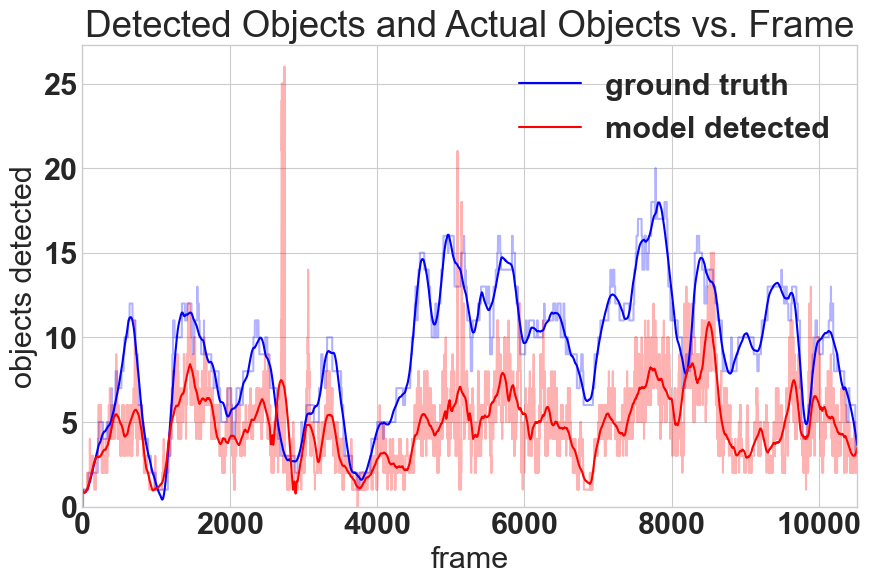

In [37]:
# plots data if logging is true

from matplotlib import pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

plt.style.use("seaborn-v0_8-whitegrid")

font = {'weight': 'bold',
        'size': 22,
        }

text = {'usetex': True
        }

plt.rc('font', **font)

columns = ["frame", "gtobj", "cvobj"]
df = pd.read_csv(os.path.join(output_dir, log_file), usecols=columns)

df['gtobjs'] = savgol_filter(df['gtobj'], int(np.floor(len(df['gtobj']))*0.03), 3)
df['cvobjs'] = savgol_filter(df['cvobj'], int(np.floor(len(df['cvobj']))*0.03), 3)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Detected Objects and Actual Objects vs. Frame')
ax.set_xlabel('frame')
ax.set_ylabel('objects detected')

ax.plot(df['frame'], df['gtobj'], color='blue', alpha=0.3)
ax.plot(df['frame'], df['cvobj'], color='red', alpha=0.3)

ax.plot(df['frame'], df['gtobjs'], label='ground truth', color='blue')
ax.plot(df['frame'], df['cvobjs'], label='model detected', color='red')

ax.set_xbound(0, len(df['frame'].index))
ax.set_ybound(0)

ax.legend()
plt.savefig(os.path.join(output_dir, "fig"))

print("mean: ", np.mean(df['gtobj']- df['cvobj']))
print("median: ", np.median(df['gtobj']- df['cvobj']))
print("max: ", np.max(df['gtobj']- df['cvobj']))